Imports

In [48]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import mplleaflet        as mpl
import seaborn           as sns

import random
import folium

from tqdm.notebook import tqdm
%matplotlib inline

# 1. Leitura e seleção dos dados

In [2]:
filename = '/content/dataset_TSMC2014_NYC.csv'

In [3]:
%time 
df = pd.read_csv(filename, parse_dates=['utcTimestamp'])
df.head()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs


,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09+00:00
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25+00:00
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24+00:00
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41+00:00
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00+00:00


Selecionando 20 userId

In [4]:
df['userId'].nunique()

1083

In [5]:
users = random.sample(list(df['userId'].unique()),20)
user_to_drop = df[df['userId'].isin(users)==False].index
df.drop(user_to_drop, inplace=True)

In [6]:
df['userId'].nunique()

20

Ordenando os dados

In [7]:
df.sort_values(['userId','utcTimestamp'], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3849 entries, 405 to 224949
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   userId           3849 non-null   int64              
 1   venueId          3849 non-null   object             
 2   venueCategoryId  3849 non-null   object             
 3   venueCategory    3849 non-null   object             
 4   latitude         3849 non-null   float64            
 5   longitude        3849 non-null   float64            
 6   timezoneOffset   3849 non-null   int64              
 7   utcTimestamp     3849 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(3)
memory usage: 270.6+ KB


Formatando os dados

In [9]:
df['utcTimestamp'] = df['utcTimestamp'].dt.tz_localize(None)

In [10]:
df['userId'] = pd.Categorical(df['userId'])
df['venueId'] = pd.Categorical(df['venueId'])
df['venueCategoryId'] = pd.Categorical(df['venueCategoryId'])
df['venueCategory'] = pd.Categorical(df['venueCategory'])

In [11]:
df['venueId'].nunique()

1695

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3849 entries, 405 to 224949
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   userId           3849 non-null   category      
 1   venueId          3849 non-null   category      
 2   venueCategoryId  3849 non-null   category      
 3   venueCategory    3849 non-null   category      
 4   latitude         3849 non-null   float64       
 5   longitude        3849 non-null   float64       
 6   timezoneOffset   3849 non-null   int64         
 7   utcTimestamp     3849 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](1), float64(2), int64(1)
memory usage: 270.4 KB


In [13]:
df.describe(include='all' , datetime_is_numeric=True)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
count,3849.0,3849,3849,3849,3849.000000,3849.000000,3849.000000,3849
unique,20.0,1695,232,166,NaN,NaN,NaN,NaN
top,267.0,428d2880f964a520b5231fe3,4bf58dd8d48988d103941735,Bar,NaN,NaN,NaN,NaN
freq,529.0,75,175,361,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,40.778870,-73.961942,-254.481684,2012-07-26 04:44:03.737074688
min,NaN,NaN,NaN,NaN,40.572949,-74.235540,-300.000000,2012-04-03 19:33:58
25%,NaN,NaN,NaN,NaN,40.734167,-74.000613,-240.000000,2012-05-09 00:13:32
50%,NaN,NaN,NaN,NaN,40.760070,-73.975110,-240.000000,2012-06-16 20:48:12
75%,NaN,NaN,NaN,NaN,40.833502,-73.897497,-240.000000,2012-10-29 02:31:29
max,NaN,NaN,NaN,NaN,40.968601,-73.702011,-240.000000,2013-02-16 02:10:50


Dados:
* 20 Usuarios
* 1388 Locais
* 230 Categorias
* 164 Categoria do local

#2. Limpeza e transformação nos dados

## 2.1. Verificando dados nulos

In [14]:
df.isna().sum()

userId             0
venueId            0
venueCategoryId    0
venueCategory      0
latitude           0
longitude          0
timezoneOffset     0
utcTimestamp       0
dtype: int64

## 2.2 Verificando dados duplicados

In [15]:
subset = ['userId','utcTimestamp']
idx = df.duplicated(subset=subset)
df.loc[idx].shape[0]

8

In [16]:
## Deletando dados duplicados
df = df.drop_duplicates(subset=subset)

Visualizando os dados usando o mplleaflet

In [17]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.2.2


In [18]:
def show_traj_by_userId(df,
                        userId=None,
                        label_tid='userId',
                        label_latitude= 'latitude',
                        label_longitude= 'longitude',
                        figsize=(10,10),
                        markersize=5):
  
  fig = plt.figure(figsize=figsize)
  df_ = df[df[label_tid]==userId]
  print('shape total: {}   shape for id (): {}'.format(df.shape[0],userId,df_.shape[0]))

  ## Criando o ponto inicial e ponto final
  plt.plot(df_.iloc[0][label_longitude], df_.iloc[0][label_latitude], 'yo' , markersize=markersize+5)
  plt.plot(df_.iloc[-1][label_longitude], df_.iloc[-1][label_latitude], 'yX', markersize=markersize+5)

  plt.plot(df_[label_longitude], df_[label_latitude], 'b')
  plt.plot(df_.loc[:,label_longitude],df_.loc[:,label_latitude],'r.', markersize=markersize)
  
  return df_,fig

In [19]:
df.head(2)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
405,12,4b53672bf964a520199b27e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.764016,-73.829476,-240,2012-04-03 21:58:10
1312,12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-04 11:24:54


In [21]:
df_aux,fig = show_traj_by_userId(df,userId=12)
#mpl.show(fig,tiles='osm')
mpl.display(fig, tiles='cartodb_positron')

shape total: 3841   shape for id (): 12


/usr/local/lib/python3.8/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## 2.3. Criando novas features

In [22]:
def haversine(lat1,lon1,lat2,lon2,to_radians=True,earth_radius=6371):
  try:
    # Convert sinfle points to array
    if to_radians:
      lat1,lon1,lat2,lon2 = np.radians([lat1,lon1,lat2,lon2])
      a = np.sin((lat2-lat1)/2.0)**2+ np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2.0)**2
    return 2 * 1000 * earth_radius * np.arctan2(a ** 0.5, (1-a) ** 0.5)
  except Exception as e:
    print('\Error Haverside fuction')
    print('lat1:{}nion1:()\nlon2:{}'.format(lat1,lon1,lat2,lon2))
    print('type(lat1) = {}\ntype(lon1)= ()\ntype(lat2) = {}\ntype(lon2)={}\n'.format(type(lat1),type(lon1),type(lat2),type(lon2)))
    raise e

In [23]:
df['latitude'].head(2)

405     40.764016
1312    40.703532
Name: latitude, dtype: float64

In [24]:
df['latitude'].shift(1).head(2)

405           NaN
1312    40.764016
Name: latitude, dtype: float64

In [25]:
prev_lat = df['latitude'].shift(1)
prev_lon = df['longitude'].shift(1)

In [26]:
df['dist_to_prev'] = haversine(prev_lat,prev_lon, df['latitude'],df['longitude'])

In [27]:
df.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,dist_to_prev
405,12,4b53672bf964a520199b27e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.764016,-73.829476,-240,2012-04-03 21:58:10,NaN
1312,12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-04 11:24:54,7104.520035
2333,12,4a2c6356f964a52057971fe3,4bf58dd8d48988d1ff941735,Miscellaneous Shop,40.762168,-73.831571,-240,2012-04-04 22:46:01,6970.818025
2494,12,4b53672bf964a520199b27e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.763963,-73.829124,-240,2012-04-04 23:43:16,286.836692
2688,12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-05 11:04:28,7089.397253


In [28]:
df.set_index('userId',inplace=True)
users = df.index

In [29]:
for u in tqdm(users):
  curr_lat = df.at[u,'latitude']
  curr_lon = df.at[u,'longitude']

  size_id = curr_lat.size

  if size_id <= 1:
    print('...id:(), must have at least 2 GPS points\n'.format(idx))
    df.at[u, 'dist_to_prev'] = np.nan

  else :
    prev_lat = curr_lat.shift(1)
    prev_lon = curr_lon.shift(1)

    df.at[u, 'dist_to_prev'] = haversine(prev_lat, prev_lon, curr_lat, curr_lon)

  0%|          | 0/3841 [00:00<?, ?it/s]

In [30]:
df.at[u,'dist_to_prev'] = haversine(prev_lat,prev_lon,curr_lat,curr_lon)

In [31]:
df.head()

,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,dist_to_prev
userId,,,,,,,,
12,4b53672bf964a520199b27e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.764016,-73.829476,-240,2012-04-03 21:58:10,NaN
12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-04 11:24:54,7104.520035
12,4a2c6356f964a52057971fe3,4bf58dd8d48988d1ff941735,Miscellaneous Shop,40.762168,-73.831571,-240,2012-04-04 22:46:01,6970.818025
12,4b53672bf964a520199b27e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.763963,-73.829124,-240,2012-04-04 23:43:16,286.836692
12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-05 11:04:28,7089.397253


In [32]:
users=df.index

In [37]:
list(df.at[u,'latitude'])[0]

40.77142562

In [40]:
df['time_to_prev']=-1.0

for u in tqdm(users):
  curr_lat = list(df.at[u,'latitude'])[0]
  curr_lon = list(df.at[u,'longitude'])[0]

  size_id = curr_lat
  

  if size_id <= 1:
    print('...id:(), must have at least 2 GPS points\n'.format(idx))
    df.at[u,'time_to_prev']=np.nan
  else:
    time_curr = pd.Series(df.at[u,'utcTimestamp'])
    time_prev = (time_curr - time_curr.shift(1))
    df.at[u,'time_to_prev']= time_prev

  0%|          | 0/3841 [00:00<?, ?it/s]

In [41]:
df['time_to_prev'].head()

userId
12                NaT
12    0 days 13:26:44
12    0 days 11:21:07
12    0 days 00:57:15
12    0 days 11:21:12
Name: time_to_prev, dtype: object

In [42]:
df['time_to_prev'] = pd.to_timedelta(df['time_to_prev']).dt.total_seconds()

In [43]:
df['speed_to_prev'] = df['dist_to_prev']/df['time_to_prev']

In [44]:
df.describe(percentiles=[0.90,0.95,0.99])

,latitude,longitude,timezoneOffset,dist_to_prev,time_to_prev,speed_to_prev
count,3841.000000,3841.000000,3841.000000,3821.000000,3.821000e+03,3821.000000
mean,40.778847,-73.961872,-254.511846,4860.092395,1.231691e+05,12.853505
std,0.071821,0.087083,25.696089,5964.213772,4.103736e+05,106.177130
min,40.572949,-74.235540,-300.000000,0.000000,5.000000e+00,0.000000
50%,40.760070,-73.975110,-240.000000,2563.466746,2.577100e+04,0.104039
90%,40.890028,-73.845506,-240.000000,13850.137705,2.832500e+05,3.354542
95%,40.911923,-73.826151,-240.000000,18024.701194,5.080140e+05,12.162865
99%,40.945255,-73.782377,-240.000000,26120.583370,1.640854e+06,367.174197
max,40.968601,-73.702011,-240.000000,37811.984044,1.236662e+07,2339.626400


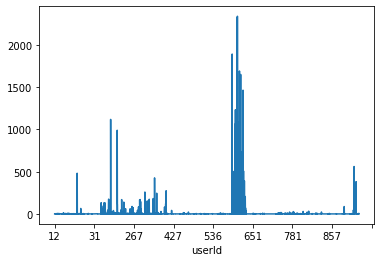

In [45]:
df['speed_to_prev'].plot()

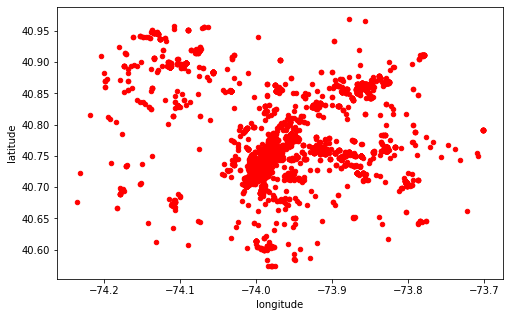

In [46]:
fig, ax = plt.subplots(figsize=(8,5))
df.plot('longitude','latitude',kind='scatter', color='r', ax=ax)

In [51]:
df.head()

,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,dist_to_prev,time_to_prev,speed_to_prev
userId,,,,,,,,,,
12,4b53672bf964a520199b27e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.764016,-73.829476,-240,2012-04-03 21:58:10,NaN,NaN,NaN
12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-04 11:24:54,7104.520035,48404.0,0.146775
12,4a2c6356f964a52057971fe3,4bf58dd8d48988d1ff941735,Miscellaneous Shop,40.762168,-73.831571,-240,2012-04-04 22:46:01,6970.818025,40867.0,0.170573
12,4b53672bf964a520199b27e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.763963,-73.829124,-240,2012-04-04 23:43:16,286.836692,3435.0,0.083504
12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-05 11:04:28,7089.397253,40872.0,0.173454


In [61]:
df = df[df['speed_to_prev'].isna()==False]

In [68]:
df.head()

,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,dist_to_prev,time_to_prev,speed_to_prev
userId,,,,,,,,,,
12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-04 11:24:54,7104.520035,48404.0,0.146775
12,4a2c6356f964a52057971fe3,4bf58dd8d48988d1ff941735,Miscellaneous Shop,40.762168,-73.831571,-240,2012-04-04 22:46:01,6970.818025,40867.0,0.170573
12,4b53672bf964a520199b27e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.763963,-73.829124,-240,2012-04-04 23:43:16,286.836692,3435.0,0.083504
12,4cd95a235e1b721e58b23ed9,4bf58dd8d48988d143941735,Breakfast Spot,40.703532,-73.802305,-240,2012-04-05 11:04:28,7089.397253,40872.0,0.173454
12,4b5fbcf0f964a520b2ca29e3,4bf58dd8d48988d10f951735,Drugstore / Pharmacy,40.605899,-73.984538,-240,2012-04-06 15:16:32,18819.682612,101524.0,0.185372


In [72]:
user_to_drop = df[df['speed_to_prev']>20].index
df.drop(user_to_drop, inplace=True)
print('{} pontos foram removidos.'.format(len(user_to_drop)))

165 pontos foram removidos.


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
